In [1]:
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import numpy as np
import pandas as pd
import scipy as sp
from scipy import interpolate
import os
import urllib.request
import tempfile

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

## Creation of the data base for thickness

In [2]:
# Use either Oise_Thickness.csv, Oise_Thickness_withSides.csv or Oise_Ztop500.csv
# Data files are available here: https://soft.mines-paristech.fr/gstlearn/data-latest/Alluvial
filename = gdoc.loadData("Alluvial", "Oise_Ztop500.csv")
csv = gl.CSVformat(True, 0, ";", ",", "9999")
data = gl.Db.createFromCSV(filename, csv, False)
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 1
Number of Columns            = 5
Total number of samples      = 2470

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = X - Locator = x1
Column = 2 - Name = Y - Locator = NA
Column = 3 - Name = Z - Locator = NA
Column = 4 - Name = Z_1 - Locator = z1

In [3]:
data.setLocator("X",gl.ELoc.X,0)
data.setLocator("Y",gl.ELoc.X,1)
data.setLocator("Z",gl.ELoc.L,0)
data.setLocator("Z_1",gl.ELoc.U,0)
sf = gl.DbStringFormat()
sf.setFlags(flag_stats=True) 
thickness = data.getWithinBounds(0)
err = data.addColumns(thickness,"Elev",gl.ELoc.Z)
err = gl.DbHelper.db_duplicate(data)
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 7
Total number of samples      = 2470
Number of active samples     = 2470

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = X - Locator = x1
Column = 2 - Name = Y - Locator = x2
Column = 3 - Name = Z - Locator = lower1
Column = 4 - Name = Z_1 - Locator = upper1
Column = 5 - Name = Elev - Locator = z1
Column = 6 - Name = Duplicate - Locator = sel

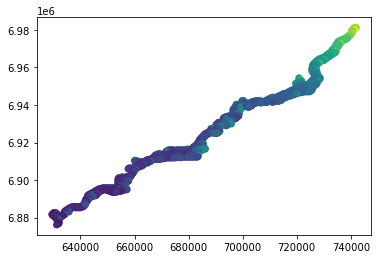

In [4]:
plt.scatter(data.getColumn("X"), data.getColumn("Y"), c=data.getColumn("Elev"))

(array([120., 787., 658., 447., 198., 118.,  63.,  51.,  22.,   6.]),
 array([ 16. ,  24.4,  32.8,  41.2,  49.6,  58. ,  66.4,  74.8,  83.2,
         91.6, 100. ]),
 <BarContainer object of 10 artists>)

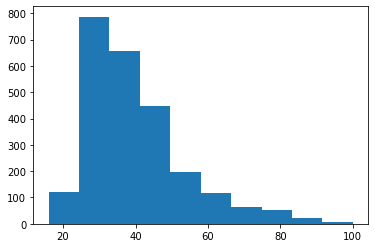

In [5]:
plt.hist(thickness)

In [6]:
#data.dumpToNF("Oise_Data_Elev500.ascii")

## Creation of the grid

### 1) Creation of the polygon

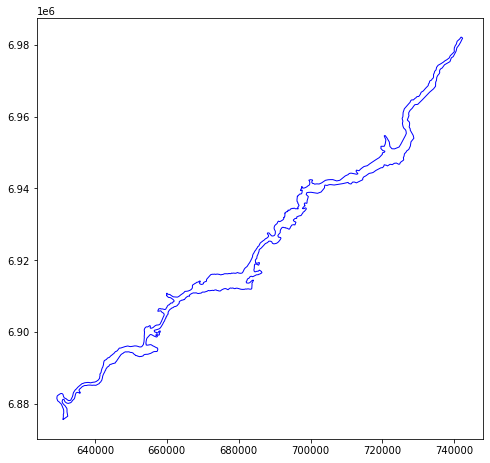

In [7]:
# Data files are available here: https://soft.mines-paristech.fr/gstlearn/data-latest/Alluvial
filename = gdoc.loadData("Alluvial", "Oise_Shapefile_AlluvialPlain.csv")
poly = gl.Polygons.createFromCSV(filename, csv, False)
ax = poly.plot()

In [8]:
grid = gl.DbGrid.create(nx = [3300,400],dx = [50.,50.], x0 = [630000.,6865000.],angles=[40,0])

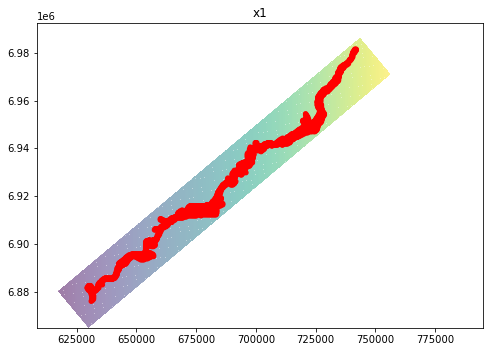

In [9]:
fig, ax = gp.initGeographic()
ax.raster(grid,"x1",alpha=0.3)
ax.symbol(data)

In [10]:
err = gl.db_polygon(grid,poly)
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 1320000
Number of active samples     = 138248

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766     0.643
     [  1,]    -0.643     0.766

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Polygon - Locator = sel

### 2) Creation of angles

In [11]:
# Data files are available here: https://soft.mines-paristech.fr/gstlearn/data-latest/Alluvial
filename = gdoc.loadData("Alluvial", "Oise_Shapefile_Centerline.csv")
## Loading Centerline data from file
df1 = pd.read_csv (filename, sep=';')
xc = list(df1['X'])
yc = list(df1['Y'])
x1=xc[1:499]
y1=yc[1:499]

# Data files are available here: https://soft.mines-paristech.fr/gstlearn/data-latest/Alluvial
filename = gdoc.loadData("Alluvial", "Oise_Shapefile_AlluvialPlain.csv")
## Loading alluvial plain contours from file & Separate into two polylines 
df = pd.read_csv (filename, sep=';')
xp = list(df['X'])
yp = list(df['Y'])
x2=xp[1:xp.index(max(xp))]
x3=xp[len(xp):xp.index(max(xp))+1:-1]
y2=yp[1:xp.index(max(xp))]
y3=yp[len(xp):xp.index(max(xp))+1:-1]

## Adding supplementary control points at the edges
# coordinates of extremes
XA1=640000
YA1=6875000
XB1=740000
YB1=6955000

XA2=630000
YA2=6890000
XB2=735000
YB2=6980000

# Forming two supplementary vectors at the edges
n=19
x4= np.zeros(n)
y4= np.zeros(n)
x5= np.zeros(n)
y5= np.zeros(n)
for i in range(0,len(x4)):
    x4[i]=(XA1+(XB1-XA1)/(n-1)*i)
    y4[i]=(YA1+(YB1-YA1)/(n-1)*i)
    x5[i]=(XA2+(XB2-XA2)/(n-1)*i)
    y5[i]=(YA2+(YB2-YA2)/(n-1)*i)

In [12]:
# Gradient method
#  https://stackoverflow.com/questions/28269379/curve-curvature-in-numpy
dx_dt1 = np.gradient(x1)
dy_dt1 = np.gradient(y1)
velocity = np.array([ [dx_dt1[i], dy_dt1[i]] for i in range(dx_dt1.size)])
ds_dt1 = np.sqrt(dx_dt1 * dx_dt1 + dy_dt1 * dy_dt1)
tangent1 = np.array([1/ds_dt1] * 2).transpose() * velocity

dx_dt2 = np.gradient(x2)
dy_dt2 = np.gradient(y2)
velocity2 = np.array([ [dx_dt2[i], dy_dt2[i]] for i in range(dx_dt2.size)])
ds_dt2 = np.sqrt(dx_dt2 * dx_dt2 + dy_dt2 * dy_dt2)
tangent2 = np.array([1/ds_dt2] * 2).transpose() * velocity2

dx_dt3 = np.gradient(x3)
dy_dt3 = np.gradient(y3)
velocity3 = np.array([ [dx_dt3[i], dy_dt3[i]] for i in range(dx_dt3.size)])
ds_dt3 = np.sqrt(dx_dt3 * dx_dt3 + dy_dt3 * dy_dt3)
tangent3 = np.array([1/ds_dt3] * 2).transpose() * velocity3

dx_dt4 = np.gradient(x4)
dy_dt4 = np.gradient(y4)
velocity4 = np.array([ [dx_dt4[i], dy_dt4[i]] for i in range(dx_dt4.size)])
ds_dt4 = np.sqrt(dx_dt4 * dx_dt4 + dy_dt4 * dy_dt4)
tangent4 = np.array([1/ds_dt4] * 2).transpose() * velocity4

dx_dt5 = np.gradient(x5)
dy_dt5 = np.gradient(y5)
velocity5 = np.array([ [dx_dt5[i], dy_dt5[i]] for i in range(dx_dt5.size)])
ds_dt5 = np.sqrt(dx_dt5 * dx_dt5 + dy_dt5 * dy_dt5)
tangent5 = np.array([1/ds_dt5] * 2).transpose() * velocity5
    
tangent=np.concatenate((tangent1,tangent2,tangent3,tangent4,tangent5),axis=0) 

x0=np.concatenate((x1,x2,x3,x4,x5),axis=0) 
y0=np.concatenate((y1,y2,y3,y4,y5),axis=0) 
u0 = tangent[:, 0]
v0 = tangent[:, 1]

(array([ 23.,  11.,   8.,  36., 238., 545., 700., 270.,  98.,  41.]),
 array([-178.33971763, -142.50574587, -106.6717741 ,  -70.83780234,
         -35.00383058,    0.83014118,   36.66411295,   72.49808471,
         108.33205647,  144.16602824,  180.        ]),
 <BarContainer object of 10 artists>)

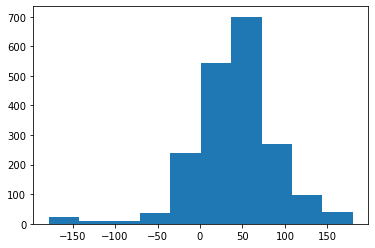

In [13]:
# Numpy arctan2 Method
angles = np.arctan2(v0, u0) * 180 / np.pi
plt.hist(angles)

In [14]:
# Interpolating the angles into angles map -> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

xx = np.linspace(630000, 742000, 2240)
yy = np.linspace(6875000, 6982200, 2144)
xx, yy = np.meshgrid(xx, yy)

angles.shape=(np.size(angles),)
np.shape(angles)

points = np.transpose(np.vstack((x0, y0)))
angles_interp = interpolate.griddata(points, angles, (xx, yy), method='linear')

xx1 = np.concatenate(xx)
yy1 = np.concatenate(yy)
angles_interp1 = np.concatenate(angles_interp)

In [15]:
#Create a point Db point using xx, yy, angles_interp
dbv = gl.Db()
dbv.addColumns(xx1,"xx",gl.ELoc.X, 0)
dbv.addColumns(yy1,"yy",gl.ELoc.X, 1)
dbv.addColumns(angles_interp1,"angles_interp",gl.ELoc.Z, 0)
dbv.display()
grid.setLocator("Pol*")
grid.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 3
Total number of samples      = 4802560

Variables
---------
Column = 0 - Name = xx - Locator = x1
Column = 1 - Name = yy - Locator = x2
Column = 2 - Name = angles_interp - Locator = z1
 
Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 1320000

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766     0.643
     [  1,]    -0.643     0.766

Variab

In [16]:
#Tester la valeur retournée par migrate :
grid.deleteColumn("Migr*")
gl.migrateMulti(dbv, grid, ["angles_interp"])
grid.setLocator("Migrate*", gl.ELoc.Z)
grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 1320000

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766     0.643
     [  1,]    -0.643     0.766

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Polygon - Locator = NA
Column = 4 - Name = Migrate.angles_interp - Locator = z1
 

In [17]:
grid.useSel = False
grid.setLocator("Polygon")
uid_selection=grid.addSelectionByLimit("*angles_interp*", gl.Limits([-10], [10]), "angle_define")

In [18]:
xplt = grid.getColumnByLocator(gl.ELoc.X,0,useSel=True)
yplt = grid.getColumnByLocator(gl.ELoc.X,1,useSel=True)
aplt = grid.getColumnByLocator(gl.ELoc.Z,0,useSel=True)

### 3) Creation of a selection (polygon + borders by morphological dilation)

In [19]:
grid.setLocator("Poly*", gl.ELoc.SEL)

In [20]:
vmin = 0.5
vmax = 1.5
nxy = grid.getNXs()
image2 = gl.BImage(nxy)

tab = grid.getColumn("Polygon",useSel=False)
image = gl.morpho_double2image(nxy,tab,vmin,vmax)
localVD = gl.VectorDouble(len(tab))
gl.morpho_dilation(0, [3,3], image, image2)
for i in range(10):
    gl.morpho_dilation(0, [1,1], image, image2)
    gl.morpho_dilation(0, [1,1], image2, image)
#gl.morpho_dilation(0, [1,1], image, image2)

gl.morpho_image2double(image2, 0, 1., 0., localVD)

In [21]:
grid["res"]=localVD.getVector()

In [22]:
grid.setLocator("res",gl.ELoc.SEL)
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 7
Total number of samples      = 1320000
Number of active samples     = 278129

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766     0.643
     [  1,]    -0.643     0.766

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Polygon - Locator = NA
Column = 4 - Name = Migrate.angles_interp - Locator = z1
Column = 5 - Name = angle_define - Locator = NA
Column = 6 - Name = res - Locator = sel

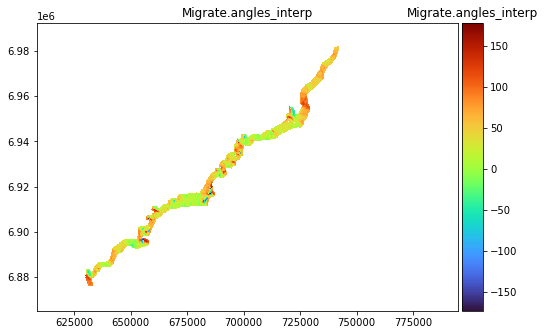

In [23]:
gp.raster(grid,"Migrate.angles_interp",cmap="turbo", flagLegend = True)

### 4) Save the result

In [24]:
#grid.dumpToNF("Oise_GridAnglesModifFinal.ascii")

# Start Kriging here once data is properly saved

In [25]:
#grid = gl.DbGrid.createFromNF("Oise_GridAnglesModifFinal.ascii")
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 7
Total number of samples      = 1320000
Number of active samples     = 278129

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766     0.643
     [  1,]    -0.643     0.766

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Polygon - Locator = NA
Column = 4 - Name = Migrate.angles_interp - Locator = z1
Column = 5 - Name = angle_define - Locator = NA
Column = 6 - Name = res - Locator = sel

In [26]:
# Modify the ranges to 8000, 800 if wished
ranges = [2000,200]
#If old method is set to True, a classical SPDE kriging will be used
oldMethod = False

In [27]:
# Load data, use either with or without the sides; For the top of the alluvial plain use "Oise_Data_Elev500.ascii"
# Data files are available here: https://soft.mines-paristech.fr/gstlearn/data-latest/Alluvial
filename = gdoc.loadData("Alluvial", "Oise_Data_ThicknessSides.ascii")
data = gl.Db.createFromNF(filename)
data

Current directory is /home/fors/Projets/gstlearn/gstlearn/doc/demo/python
./Oise_Data_ThicknessSides.ascii not found...
./doc/data/Alluvial/Oise_Data_ThicknessSides.ascii not found...
../../data/Alluvial/Oise_Data_ThicknessSides.ascii found... Full path is /home/fors/Projets/gstlearn/gstlearn/doc/data/Alluvial/Oise_Data_ThicknessSides.ascii



Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 7
Total number of samples      = 2334
Number of active samples     = 2319

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = X - Locator = x1
Column = 2 - Name = Y - Locator = x2
Column = 3 - Name = Thickness - Locator = lower1
Column = 4 - Name = Thickness_1 - Locator = upper1
Column = 5 - Name = ThicknessSides - Locator = z1
Column = 6 - Name = Duplicate - Locator = sel

In [28]:
# Selection to calculate variogram only on non-zero values
data["selVario"]=(data["Duplicate"]*(data["ThicknessSides"]>0))
data.setLocators(["selVario"],gl.ELoc.SEL)
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 8
Total number of samples      = 2334
Number of active samples     = 1010

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = X - Locator = x1
Column = 2 - Name = Y - Locator = x2
Column = 3 - Name = Thickness - Locator = lower1
Column = 4 - Name = Thickness_1 - Locator = upper1
Column = 5 - Name = ThicknessSides - Locator = z1
Column = 6 - Name = Duplicate - Locator = NA
Column = 7 - Name = selVario - Locator = sel

In [ ]:
myVarioParamBidir = gl.VarioParam()
mydir = gl.DirParam(40,800.,0.5,45.,0,0,np.nan,np.nan,0.,[],[1,1])
myVarioParamBidir.addDir(mydir)
mydir = gl.DirParam(20,400.,0.5,45.,0,0,np.nan,np.nan,0.,[],[-1,1])
myVarioParamBidir.addDir(mydir)
myVarioBidir = gl.Vario(myVarioParamBidir)
err = myVarioBidir.compute(data,gl.ECalcVario.VARIOGRAM)
myVarioBidir.display()
ax = gp.varmod(myVarioBidir,idir=0)
ax.decoration(title="Bi-directional Variogram for thickness(45°)")
ax = gp.varmod(myVarioBidir,idir=1)
ax.decoration(title="Bi-directional Variogram for thickness(45/135°)")

In [ ]:
model = gl.Model.createFromDb(data)

structs = [gl.ECov.NUGGET,gl.ECov.BESSEL_K]
cons1P = gl.ConsItem.define(gl.EConsElem.PARAM,1, type = gl.EConsType.EQUAL,value = 1)

a = gl.Constraints()
a.addItem(cons1P)

err = model.fit(myVarioBidir,structs,constraints=a)
model.display()
ax = gp.varmod(myVarioBidir,model,idir=0)
ax = gp.varmod(myVarioBidir,model,idir=1)
plt.show()

#model.setMean(100)
model.display()

In [ ]:
data.setLocators(["Duplicate"],gl.ELoc.SEL)

In [ ]:
if not oldMethod :
    model = gl.Model.createFromDb(data)
    covBessel = gl.CovAniso.createAnisotropic(type = gl.ECov.BESSEL_K,ranges=ranges,sill=4.7,param=1,ctxt=model.getContext())
    covNugget = gl.CovAniso.createIsotropic(type = gl.ECov.NUGGET,sill=2.2,ctxt=model.getContext(),range=1)
    model.addCov(covNugget)
    model.addCov(covBessel)

In [ ]:
grid.setLocator("Polygon.*", gl.ELoc.SEL)

In [ ]:
model.setDriftIRF(order = 0)
model

In [ ]:
if not oldMethod:
    grid.setLocator("Migrate.angles_interp",gl.ELoc.NOSTAT)
    nostat = gl.NoStatArray(["M2A"],grid)
    model.addNoStat(nostat)

In [ ]:
data.setLocators(["ThicknessNosides"],gl.ELoc.Z,cleanSameLocator=True)

In [ ]:
# Basic SPDE simulation 
spde = gl.SPDE(model,grid,data,gl.ESPDECalcMode.KRIGING)
uid_result= spde.compute(grid)

In [ ]:
#Plot kriging
plt.figure(figsize=[20,12])
gp.raster(grid,"spde.ThicknessSides.estim",cmap="turbo", flagLegend = True)

# Save the current grid, which can be loaded again at the start of kriging (cell #26)

In [ ]:
# modify the grid according to your wishes
#grid["Old_Variable"]=grid["New_variable"]
#grid.deleteColumn("TheVariableYouWant")
#grid["BedrockElevation"]=grid["PlainElevation"]-grid["AlluviumThickness"]

In [ ]:
#Save the grid
#grid.dumpToNF("Oise_KrigingResults_Thickness.ascii")

# Uncertainties estimation based on standard deviation

In [ ]:
# Calculation of n simulations to estimate standard deviation (best is to change to nbsimu=100)
error=gl.simulateSPDE(data,grid,model,nbsimu=10)

In [ ]:
# Calculation of Stdv by hand: gl.EStatOption.STDV in the future
grid["MeanSimu"]=grid["SimuSPDE.Thickness*"].mean(1)
grid["StdevSimu"]=np.zeros(grid["SimuSPDE.Thickness*"].shape[0])
nc=grid["SimuSPDE.Thickness*"].shape[1]
for i in range(nc):
    grid["StdevSimu"]+=((grid["SimuSPDE.Thickness*"][:,i]-grid["MeanSimu"])**2)/nc
grid["StdevSimu"]=grid["StdevSimu"]**0.5